# AI Engineer Task: IMDb Movie Review Sentiment Analysis
This notebook contains the complete solution for the sentiment analysis task. The process includes data preparation, training a Logistic Regression model, optimizing it with GridSearchCV, and building an optional LSTM deep learning model.

In [17]:
# Import necessary libraries
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

# Download NLTK stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Step 1: Data Preparation and Cleaning

In [18]:
# Load the datasets
try:
    train_df = pd.read_csv('train_data (1).csv')
    test_df = pd.read_csv('test_data (1).csv')
except FileNotFoundError:
    print("Make sure 'train_data (1).csv' and 'test_data (1).csv' are uploaded to your Colab environment.")

# Display the first few rows of the training data
print("Training Data Head:")
print(train_df.head())

# Display the first few rows of the testing data
print("\nTesting Data Head:")
print(test_df.head())

Training Data Head:
                                                   0  1
0  This film is absolutely awful, but nevertheles...  0
1  Well since seeing part's 1 through 3 I can hon...  0
2  I got to see this film at a preview and was da...  1
3  This adaptation positively butchers a classic ...  0
4  Råzone is an awful movie! It is so simple. It ...  0

Testing Data Head:
                                                   0  1
0  I did not enjoy the film Eraser whatsoever. It...  0
1  Be very afraid of anyone who likes this film. ...  0
2  The 3rd and last big screen spin off from the ...  0
3  Barely three and a half years after just scrap...  1
4  I'm a big fan of the demonic puppets. Looking ...  0


In [19]:
# Define the text cleaning function
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove punctuation and numbers
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    # Convert to lowercase
    text = text.lower()
    # Tokenize the text and remove stopwords
    words = text.split()
    words = [w for w in words if not w in stop_words]
    return ' '.join(words)

# Apply the cleaning function to the review columns
train_df['cleaned_review'] = train_df['0'].apply(clean_text)
test_df['cleaned_review'] = test_df['0'].apply(clean_text)

print("Cleaned Training Data Head:")
print(train_df[['0', 'cleaned_review']].head())

Cleaned Training Data Head:
                                                   0  \
0  This film is absolutely awful, but nevertheles...   
1  Well since seeing part's 1 through 3 I can hon...   
2  I got to see this film at a preview and was da...   
3  This adaptation positively butchers a classic ...   
4  Råzone is an awful movie! It is so simple. It ...   

                                      cleaned_review  
0  film absolutely awful nevertheless hilarious t...  
1  well since seeing part honestly say never made...  
2  got see film preview dazzled typical romantic ...  
3  adaptation positively butchers classic beloved...  
4  r zone awful movie simple seems tried make mov...  


In [20]:
# Splitting the training data
X = train_df['cleaned_review']
y = train_df['1'] # Assuming '1' is the sentiment column (0 for negative, 1 for positive)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")

Training set size: 20000
Validation set size: 5000


## Step 2 & 3: Logistic Regression - Training, Evaluation, and Optimization
### 2.1 Feature Engineering with TF-IDF

In [21]:
# Initialize the TF-IDF Vectorizer
# We use max_features=5000 to keep the vocabulary size manageable and focus on the most important words.
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# Fit the vectorizer ONLY on the training data to prevent data leakage from the validation set.
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transform the validation data using the already-fitted vectorizer.
X_val_tfidf = tfidf_vectorizer.transform(X_val)

### 2.2 Baseline Model Training & Evaluation

In [22]:
# Initialize and train the Logistic Regression model
log_reg_model = LogisticRegression(random_state=42, max_iter=1000) # Increased max_iter for convergence
log_reg_model.fit(X_train_tfidf, y_train)

# Make predictions on the validation set
y_pred_lr = log_reg_model.predict(X_val_tfidf)

Logistic Regression Model Evaluation:
Accuracy: 0.8908
Precision: 0.8706
Recall: 0.9150
F1-score: 0.8923


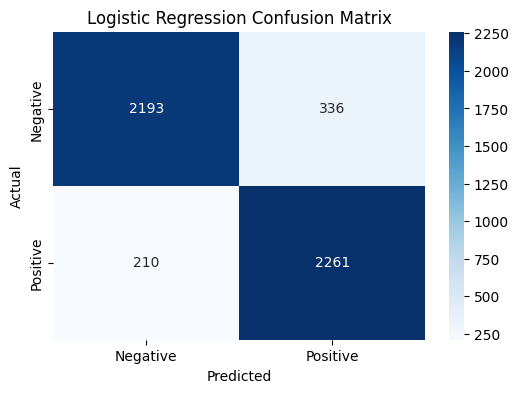

In [23]:
# Calculate evaluation metrics
accuracy_lr = accuracy_score(y_val, y_pred_lr)
precision_lr = precision_score(y_val, y_pred_lr)
recall_lr = recall_score(y_val, y_pred_lr)
f1_lr = f1_score(y_val, y_pred_lr)

print("Logistic Regression Model Evaluation:")
print(f"Accuracy: {accuracy_lr:.4f}")
print(f"Precision: {precision_lr:.4f}")
print(f"Recall: {recall_lr:.4f}")
print(f"F1-score: {f1_lr:.4f}")

# Generate and display the confusion matrix
cm_lr = confusion_matrix(y_val, y_pred_lr)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

### 2.3 Hyperparameter Optimization with GridSearchCV
This step systematically searches for the best model parameters to fulfill the "Optimize model parameters" requirement.

In [24]:
# (Add this import at the top of your first cell)
from sklearn.model_selection import GridSearchCV

# --- NEW CELL: Hyperparameter Tuning with GridSearchCV ---

# Define the parameter grid to search
param_grid = {
    'C': [0.1, 1, 10],  # Regularization strength
    'solver': ['liblinear', 'saga'] # Solvers that work well with L1/L2
}

# Initialize the Grid Search model
grid_search = GridSearchCV(
    LogisticRegression(random_state=42, max_iter=2000),
    param_grid,
    cv=3, # 3-fold cross-validation
    scoring='accuracy',
    verbose=1,
    n_jobs=-1 # Use all available CPU cores
)

# Fit the grid search to the data
print("Starting Grid Search for Logistic Regression...")
grid_search.fit(X_train_tfidf, y_train)

# Print the best parameters and the best score
print(f"Best Parameters found: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

# The grid_search object now holds the best model
best_log_reg_model = grid_search.best_estimator_

# (Optional) You can now re-evaluate this best model on your validation set
# y_pred_best_lr = best_log_reg_model.predict(X_val_tfidf)
# print(f"Validation accuracy of best model: {accuracy_score(y_val, y_pred_best_lr):.4f}")

Starting Grid Search for Logistic Regression...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Parameters found: {'C': 1, 'solver': 'liblinear'}
Best cross-validation accuracy: 0.8766


### 2.4 Saving the Best Model

In [25]:
# Save the BEST trained model and the vectorizer
with open('best_logistic_regression_model.pkl', 'wb') as model_file:
    # Save the best estimator found by Grid Search
    pickle.dump(best_log_reg_model, model_file)

with open('tfidf_vectorizer.pkl', 'wb') as vec_file:
    pickle.dump(tfidf_vectorizer, vec_file)

print("Best model and TF-IDF vectorizer saved successfully.")

Model and TF-IDF vectorizer saved successfully.


## Step 4 (Bonus): Deep Learning Model with LSTM
### 4.1 Data Preparation for Deep Learning

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenize the text
max_words = 10000
# Define a fixed maximum length for sequences
maxlen = 250

tokenizer = Tokenizer(num_words=max_words, split=' ')
tokenizer.fit_on_texts(train_df['cleaned_review'].values)

X_dl = tokenizer.texts_to_sequences(train_df['cleaned_review'].values)
# Apply padding and truncating
X_dl = pad_sequences(X_dl, maxlen=maxlen)

# Split the data
y_dl = pd.get_dummies(train_df['1']).values
X_train_dl, X_val_dl, y_train_dl, y_val_dl = train_test_split(X_dl, y_dl, test_size=0.2, random_state=42)

print(f"Shape of padded training data: {X_train_dl.shape}")

Shape of padded training data: (20000, 250)


### 4.2 Building and Training the LSTM Model
We include an EarlyStopping callback to prevent overfitting and save the best version of the model during training.

In [27]:
# (Add this import at the top of the cell)
from tensorflow.keras.callbacks import EarlyStopping

# Build the LSTM model
embedding_dim = 128
lstm_out = 196

model_lstm = Sequential()
# The input_length is now inferred automatically from the data shape
model_lstm.add(Embedding(max_words, embedding_dim))
model_lstm.add(SpatialDropout1D(0.4))
model_lstm.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model_lstm.add(Dense(2, activation='softmax'))
model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model_lstm.summary())

# Train the model with Early Stopping
batch_size = 32
# This callback will stop training when 'val_loss' hasn't improved for 2 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

model_lstm.fit(X_train_dl, y_train_dl,
               epochs=10,  # We can set a higher epoch number; early stopping will handle it
               batch_size=batch_size,
               validation_data=(X_val_dl, y_val_dl),
               callbacks=[early_stopping], # Add the callback here
               verbose=2)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_2             │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
625/625 - 293s - 469ms/step - accuracy: 0.7984 - loss: 0.4369 - val_accuracy: 0.8568 - val_loss: 0.3369
Epoch 2/10
625/625 - 290s - 464ms/step - accuracy: 0.8896 - loss: 0.2795 - val_accuracy: 0.8624 - val_loss: 0.3571
Epoch 3/10
625/625 - 341s - 545ms/step - accuracy: 0.9219 - loss: 0.2098 - val_accuracy: 0.8876 - val_loss: 0.3130
Epoch 4/10
625/625 - 300s - 480ms/step - accuracy: 0.9362 - loss: 0.1701 - val_accuracy: 0.8750 - val_loss: 0.3396
Epoch 5/10
625/625 - 340s - 545ms/step - accuracy: 0.9553 - loss: 0.1259 - val_accuracy: 0.8716 - val_loss: 0.3913


### 4.3 Evaluating and Saving the LSTM Model

157/157 - 21s - 132ms/step - accuracy: 0.8758 - loss: 0.3130
LSTM Model Accuracy: 0.8876
157/157 ━━━━━━━━━━━━━━━━━━━━ 22s 136ms/step
Precision: 0.8594
Recall: 0.8952
F1-score: 0.8769


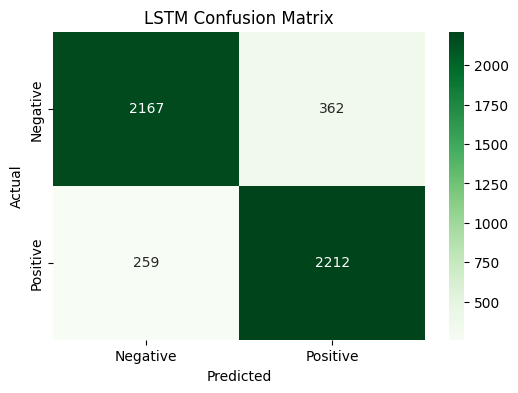

LSTM Model and tokenizer saved successfully.


In [28]:
# Evaluate the LSTM model
score, acc = model_lstm.evaluate(X_val_dl, y_val_dl, verbose=2, batch_size=batch_size)
print(f"LSTM Model Accuracy: {acc:.4f}")

# To get other metrics, we need to make predictions and convert them from probabilities
y_pred_lstm_prob = model_lstm.predict(X_val_dl)
y_pred_lstm = np.argmax(y_pred_lstm_prob, axis=1)
y_true_lstm = np.argmax(y_val_dl, axis=1)

precision_lstm = precision_score(y_true_lstm, y_pred_lstm)
recall_lstm = recall_score(y_true_lstm, y_pred_lstm)
f1_lstm = f1_score(y_true_lstm, y_pred_lstm)

print(f"Precision: {precision_lstm:.4f}")
print(f"Recall: {recall_lstm:.4f}")
print(f"F1-score: {f1_lstm:.4f}")

# Generate and display the confusion matrix
cm_lstm = confusion_matrix(y_true_lstm, y_pred_lstm)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Greens', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('LSTM Confusion Matrix')
plt.show()

# Save the LSTM model
model_lstm.save('lstm_model.h5')
with open('tokenizer.pkl', 'wb') as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)
print("LSTM Model and tokenizer saved successfully.")